# Modeling  - Interpretation and Testing

The following notebook subject the data to logistic regression, and insights are extracted from it.

It also runs the model on the test data set to get a holistic picture of model performance.

## Contents

- [Logistic Regression](#logreg)
- [Interpretation](#interpret)
- [Testing the model on holdout set](#holdout)

In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import calendar
import seaborn as sns
sns.set(style='whitegrid')

import statsmodels.api as smapi

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from matplotlib import pyplot

from Utils.PipelineUtils import *
from Utils.DataUtils import *
from Utils.VizUtils import *

In [3]:
train_data = pd.read_csv("./train_data.csv")
val_data = pd.read_csv("./val_data.csv")
test_data = pd.read_csv("./test_data.csv")

significant_features = load_from_disk("./sig_features.pkl")
scaler_list = load_from_disk("./scaler_list.pkl")
le_list = load_from_disk("./label_encoders.pkl")
ohe_list = load_from_disk("./onehot_encoders.pkl")
traffic_idx_list = load_from_disk("./traffic_idx_list.pkl")

display(
    train_data.shape,
    train_data.head(),
    val_data.shape,
    val_data.head(),
    test_data.shape,
    test_data.head())

(8543, 18)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,11,604.73,0,0.0,63,1276.843158,0.0000,0.006712,0.000000,0.0,Jul,2,2,8,6,New_Visitor,False,True
1,1,59.50,0,0.0,20,646.166667,0.0000,0.025333,0.000000,0.0,Dec,2,2,9,3,Returning_Visitor,False,False
2,4,82.50,0,0.0,16,299.500000,0.0000,0.005556,0.000000,0.0,Dec,1,1,4,2,Returning_Visitor,True,False
3,0,0.00,0,0.0,8,704.166667,0.0125,0.035417,0.000000,0.0,Nov,3,2,1,3,Returning_Visitor,False,False
4,1,153.50,0,0.0,20,1002.847222,0.0000,0.009524,41.134331,0.0,Nov,2,2,4,2,Returning_Visitor,False,False


(1831, 18)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,1,30.5,1,31.0,24,533.500000,0.000000,0.040741,0.0,0.0,May,4,1,1,3,Returning_Visitor,False,False
1,4,50.5,3,54.0,41,1490.552778,0.000000,0.006589,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,19,281.433333,0.038596,0.082807,0.0,0.0,June,2,2,3,4,Returning_Visitor,False,False
3,0,0.0,0,0.0,12,292.875000,0.000000,0.028333,0.0,0.0,Nov,4,2,3,2,Returning_Visitor,True,False
4,0,0.0,0,0.0,27,867.777778,0.000000,0.004487,0.0,0.0,Dec,2,2,3,1,New_Visitor,False,False


(1831, 18)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,1,32.300000,1,26.500000,51,1068.357692,0.013725,0.043697,7.57047,0.0,Nov,2,10,2,2,Returning_Visitor,False,False
1,4,88.625000,3,170.583333,5,124.958333,0.000000,0.005556,0.00000,0.0,Nov,2,4,7,2,New_Visitor,False,False
2,1,14.000000,0,0.000000,11,239.583333,0.000000,0.016667,0.00000,0.0,Nov,2,2,6,1,Returning_Visitor,True,False
3,4,189.666667,0,0.000000,27,687.500000,0.000000,0.005069,0.00000,0.0,Dec,2,2,3,2,New_Visitor,False,False
4,1,38.000000,0,0.000000,5,131.000000,0.033333,0.013333,0.00000,0.0,Mar,1,2,1,9,New_Visitor,True,False


In [4]:
# Quick mapping
train_data["Revenue"] = train_data["Revenue"].astype(int)
val_data["Revenue"] = val_data["Revenue"].astype(int)
test_data["Revenue"] = test_data["Revenue"].astype(int)

train_data_sm = smapi.add_constant(train_data)
test_data_sm = smapi.add_constant(test_data)
val_data_sm = smapi.add_constant(val_data)

In [5]:
def preprocessing_pipeline(df, traffic_idx_list, scaler_list, le_list, ohe_list, scale_num_cols=True):
    months = [calendar.month_name[i][:3] for i in range(1,13)]
    months[5] = "June"
    df["quarter"] = df["Month"].apply(lambda x: 1+np.floor(months.index(x)/3)).astype(np.uint8)

    df["OperatingSystems_agg"] = df["OperatingSystems"].apply(lambda x: "other" if x >=4 else x)
    df["Browser_agg"] = df["Browser"].apply(lambda x: "other" if x not in [1,2,4] else x)

    df["TrafficType_agg"] = df["TrafficType"].apply(lambda x: x if x in traffic_idx_list else "other")

    df["AllPageCount"] = df[["Administrative", "Informational", "ProductRelated"]].sum(axis=1)
    df["AllPageCount_Duration"] = df[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].sum(axis=1)

    df["BounceRates_x_PageValues"] = df["BounceRates"] * df["PageValues"]
    
    # Scaling numerical columns
    if scale_num_cols:
        for c, scaler in scaler_list.items():
            df[c] = scaler.transform(df[c].values.reshape(-1,1))
        
    for c in le_list.keys():
        df[c] = df[c].astype(str)
        
    # Label encoding
    for c, le in le_list.items():
        df[c] = df[c].map(le)
        
    # Onehot encoding
    
    # Month column
    if "Month" in df.columns:
        for month in months:
            df["Month_"+month] = df["Month"].apply(lambda x: 1 if x==month else 0)
        # Also remove the Month variable from the dataframe
        df.drop("Month", inplace=True, axis=1)
    
    for colname, ohe in ohe_list.items():
#         print(colname, ohe)
        out = ohe.transform(df[colname].values.reshape(-1,1)).toarray()
        # Drop the first column - dummy variable trap
        out = out[:,1:]
        # Join with the original data frame
        dfOneHot = pd.DataFrame(out, 
                                columns=[colname+"_"+str(int(i)) for i in range(out.shape[1])], 
                                index=df.index)
        df = pd.concat([df, dfOneHot], axis=1)
        df.drop(colname, axis=1, inplace=True)
    
    return df


# Define some helper functions
def get_classification_reports(model, x_val, y_val):
    y_pred_test = model.predict(x_val) > 0.5
    # f1_score(y_true=y_train.values.ravel(), y_pred=y_pred_train, labels=["True","Pred"])

    print("Classification Reports ---\n\n")
    val_class_rep = classification_report(y_true=y_val, y_pred=y_pred_test)
    print("Validation data:\n", val_class_rep)
    f1score = f1_score(y_true=y_val.values.ravel(), y_pred=y_pred_test)
    print("F1 score:", np.round(f1score, 2))
    return f1score
    
    
def get_confusion_mat(y_true, y_pred, colnames=["Pred_0", "Pred_1"], index=["True_0", "True_1"]):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), columns=colnames, index=index)
    
    
def evaluate_model(model, alpha_val = 0.05, figsize=(12,20), show_coef_graph=False):
    pvals = model.pvalues.to_frame()
    pvals.sort_values(0, inplace=True, ascending=True)
    significant_features = pvals[pvals[0]<=alpha_val].index
    significant_features = [c for c in significant_features if "const" not in c]

    coeffs = model.params.to_frame()
    coeffs = coeffs.reset_index(drop=False)
    # coeffs = coeffs[coeffs["index"].isin(significant_features)]
    coeffs.columns = ["column", "coef"]

    f, ax = plt.subplots(2, 1, figsize=figsize)
    g = sns.barplot(y=pvals.index, x=pvals[0], ax=ax[0])
    g.set(title="P values of features", xlabel="p-value")
    g.axvline(x=alpha_val, linestyle="--")
    g = sns.barplot(y="column", x="coef", data=coeffs[coeffs["column"].isin(significant_features)], ax=ax[1])
    g.set(title="Coefficient of significant columns")
    if not show_coef_graph:
        ax[1].set(visible=False)
    plt.show()
        
    return significant_features


def pr_curve(model, x_val, y_val):
    # predict probabilities
    lr_probs = model.predict(x_val)
    # predict class values
    yhat = lr_probs > 0.5
    # calculate precision and recall for each threshold
    lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
    # calculate scores
    lr_f1, lr_auc = f1_score(y_val, yhat), auc(lr_recall, lr_precision)
    # plot the precision-recall curves
    no_skill = len(y_val[y_val==1]) / len(y_val)
#     pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    pyplot.title("AUC: " + str(np.round(lr_auc, 2)))
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

--------------

# Logistic Regression<a id='logreg'></a>

In [6]:
# Preprocess the data
train_data_sm = preprocessing_pipeline(train_data_sm, traffic_idx_list, scaler_list, le_list, ohe_list, scale_num_cols=True)
val_data_sm = preprocessing_pipeline(val_data_sm, traffic_idx_list, scaler_list, le_list, ohe_list, scale_num_cols=True)
test_data_sm = preprocessing_pipeline(test_data_sm, traffic_idx_list, scaler_list, le_list, ohe_list, scale_num_cols=True)

# Choose only the significant features
ycol = ["Revenue"]
train_data_sm = train_data_sm[significant_features+ycol + ["const"]]
val_data_sm = val_data_sm[significant_features+ycol + ["const"]]
test_data_sm = test_data_sm[significant_features+ycol + ["const"]]

display(
    train_data_sm.shape,
    train_data_sm.head(),
    val_data_sm.shape,
    val_data_sm.head(),
    test_data_sm.shape,
    test_data_sm.head())

(8543, 14)

,PageValues,ProductRelated,Month_Nov,BounceRates,Month_Dec,Informational,TrafficType_agg_7,VisitorType_1,TrafficType_agg_2,Month_Feb,TrafficType_agg_8,TrafficType_agg_3,Revenue,const
0,-0.315005,0.707024,0,-0.447944,0,-0.405807,0.0,0.0,0.0,0,0.0,0.0,1,1.0
1,-0.315005,-0.273850,0,-0.447944,1,-0.405807,0.0,1.0,0.0,0,0.0,1.0,0,1.0
2,-0.315005,-0.365094,0,-0.447944,1,-0.405807,0.0,1.0,1.0,0,0.0,0.0,0,1.0
3,-0.315005,-0.547582,1,-0.168832,0,-0.405807,0.0,1.0,0.0,0,0.0,1.0,0,1.0
4,1.863948,-0.273850,1,-0.447944,0,-0.405807,0.0,1.0,1.0,0,0.0,0.0,0,1.0


(1831, 14)

,PageValues,ProductRelated,Month_Nov,BounceRates,Month_Dec,Informational,TrafficType_agg_7,VisitorType_1,TrafficType_agg_2,Month_Feb,TrafficType_agg_8,TrafficType_agg_3,Revenue,const
0,-0.315005,-0.182606,0,-0.447944,0,0.402307,0.0,1.0,0.0,0,0.0,1.0,0,1.0
1,-0.315005,0.205182,0,-0.447944,0,2.018536,0.0,1.0,1.0,0,0.0,0.0,0,1.0
2,-0.315005,-0.296661,0,0.413877,0,-0.405807,0.0,1.0,0.0,0,0.0,0.0,0,1.0
3,-0.315005,-0.456338,1,-0.447944,0,-0.405807,0.0,1.0,1.0,0,0.0,0.0,0,1.0
4,-0.315005,-0.114173,0,-0.447944,1,-0.405807,0.0,0.0,0.0,0,0.0,0.0,0,1.0


(1831, 14)

,PageValues,ProductRelated,Month_Nov,BounceRates,Month_Dec,Informational,TrafficType_agg_7,VisitorType_1,TrafficType_agg_2,Month_Feb,TrafficType_agg_8,TrafficType_agg_3,Revenue,const
0,0.086015,0.433292,1,-0.141468,0,0.402307,0.0,1.0,1.0,0,0.0,0.0,0,1.0
1,-0.315005,-0.616015,1,-0.447944,0,2.018536,0.0,0.0,1.0,0,0.0,0.0,0,1.0
2,-0.315005,-0.479149,1,-0.447944,0,-0.405807,0.0,1.0,0.0,0,0.0,0.0,0,1.0
3,-0.315005,-0.114173,0,-0.447944,1,-0.405807,0.0,0.0,1.0,0,0.0,0.0,0,1.0
4,-0.315005,-0.616015,0,0.296356,0,-0.405807,0.0,0.0,0.0,0,1.0,0.0,0,1.0


Training Data:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7207
           1       0.61      0.69      0.64      1336

    accuracy                           0.88      8543
   macro avg       0.77      0.80      0.79      8543
weighted avg       0.89      0.88      0.88      8543

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1545
           1       0.60      0.65      0.63       286

    accuracy                           0.88      1831
   macro avg       0.77      0.79      0.78      1831
weighted avg       0.88      0.88      0.88      1831

F1 score: 0.63
Train confusion matrix:


d:\softwares\python36\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Pred_0,Pred_1
True_0,6615,592
True_1,419,917


Validation confusion matrix:


,Pred_0,Pred_1
True_0,1420,125
True_1,99,187


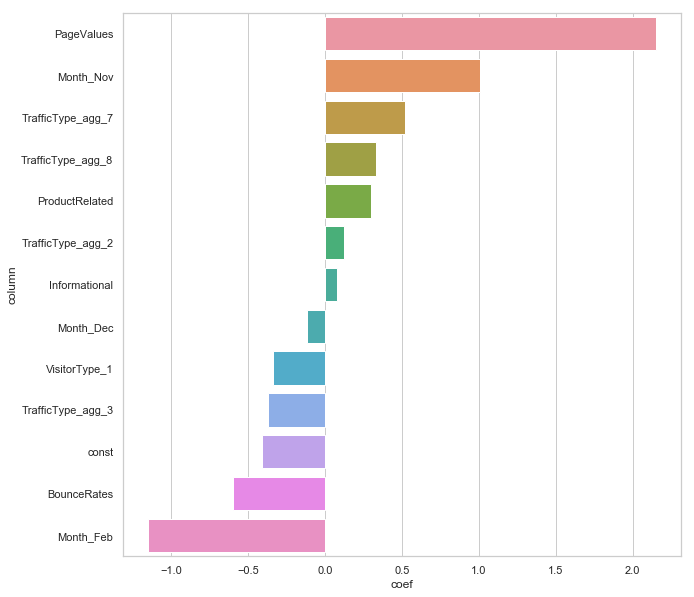

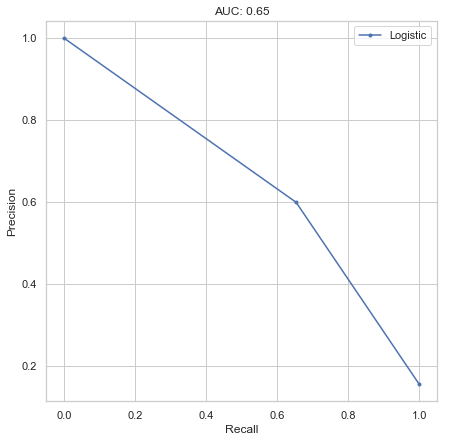

In [38]:
xcol = [c for c in train_data_sm.columns if c not in ycol]

logit = LogisticRegression(penalty='none', solver='lbfgs', class_weight={0: 0.20666666666666667, 1: 0.7933333333333333})
logit = logit.fit(X=train_data_sm[xcol], y=train_data_sm[ycol])

coef_df = pd.DataFrame(list(zip(xcol, np.round(logit.coef_[0],2))))
coef_df.columns = ["column", "coef"]
intercept = logit.intercept_
coef_df = coef_df.sort_values("coef", ascending=False)

f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(x="coef", y="column", data=coef_df, ax=ax)

train_ylabels = logit.predict(train_data_sm[xcol])
val_ylabels = logit.predict(val_data_sm[xcol])

print("Training Data:")
print(classification_report(y_true=train_data_sm["Revenue"], y_pred=train_ylabels))

get_classification_reports(logit, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

f, ax = plt.subplots(1,1,figsize=(7,7))
pr_curve(logit, val_data_sm[xcol], val_data_sm[ycol])

------------------------

,column,coef,odds_ratio,std
0,PageValues,2.15,8.584858,18.878
2,Month_Nov,1.01,2.745601,
6,TrafficType_agg_7,0.52,1.682028,
10,TrafficType_agg_8,0.33,1.390968,
1,ProductRelated,0.30,1.349859,43.8385
8,TrafficType_agg_2,0.12,1.127497,
5,Informational,0.08,1.083287,1.23745
4,Month_Dec,-0.12,0.886920,
7,VisitorType_1,-0.34,0.711770,
11,TrafficType_agg_3,-0.37,0.690734,


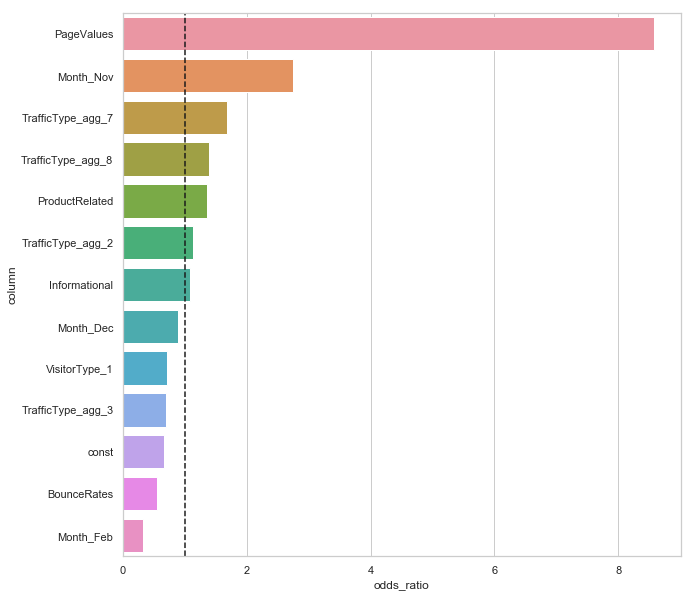

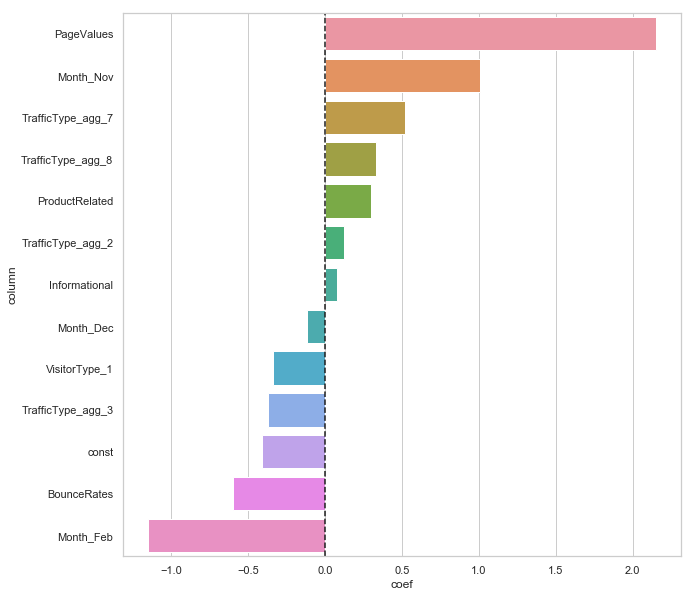

In [41]:
coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df = coef_df.sort_values("odds_ratio", ascending=False)

coef_df["std"] = coef_df.apply(lambda x: np.sqrt(scaler_list[x.column].var_[0]) if x.column in scaler_list else '', axis=1)

f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(x="odds_ratio", y="column", data=coef_df, ax=ax)
g.axvline(x=1, linestyle="--", c='k')

f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(x="coef", y="column", data=coef_df, ax=ax)
g.axvline(x=0, linestyle="--", c='k')

coef_df

In [47]:
for i in coef_df.query("coef>0")["column"].values:
    print(i, end=", ")

PageValues, Month_Nov, TrafficType_agg_7, TrafficType_agg_8, ProductRelated, TrafficType_agg_2, Informational, 

The odds ratio represents the constant effect of a predictor X, on the likelihood that one outcome will occur

# Coefficient Interpretation<a id='interpret'></a>

## Interpretation of numerical columns

### PageValues

NOTE: Average value for a webpage a user visited before completing a transaction.

In [23]:
colname = "PageValues"
q = "column==\""+colname+"\""
coef_df.query(q)

,column,coef,std,odds_ratio
0,PageValues,2.15,18.878026,8.584858


Holding all else constant, an increase of 19 in PageValues, the odds of a customer generating revenue increase 8 times.

### BounceRates

In [24]:
colname = "BounceRates"
q = "column==\""+colname+"\""
coef_df.query(q)

,column,coef,std,odds_ratio
3,BounceRates,-0.6,0.044785,0.548812


Holding all else constant, an increase of 0.04 in BounceRates, the odds of a customer generating revenue decreases by 46%.

### ProductRelated

In [25]:
colname = "ProductRelated"
q = "column==\""+colname+"\""
coef_df.query(q)

,column,coef,std,odds_ratio
1,ProductRelated,0.3,43.838465,1.349859


Holding all else constant, an increase of 43 in ProductRelated page views, the odds of a customer generating revenue increase by 33%.

### Informational

In [26]:
colname = "Informational"
q = "column==\""+colname+"\""
coef_df.query(q)

,column,coef,std,odds_ratio
5,Informational,0.08,1.237448,1.083287


Holding all else constant, an increase of 23 Informational page views, the odds of a customer generating revenue increase by 8%.

## Interpretation of categorical columns

### Traffic Types

In [27]:
rows = [i for i in coef_df["column"].values if "TrafficType" in i]
coef_df[coef_df["column"].isin(rows)]

,column,coef,std,odds_ratio
6,TrafficType_agg_7,0.52,0.0,1.682028
10,TrafficType_agg_8,0.33,0.0,1.390968
8,TrafficType_agg_2,0.12,0.0,1.127497
11,TrafficType_agg_3,-0.37,0.0,0.690734


In [28]:
# find_unique_elems([list(train_data["TrafficType"].unique()), 
#                    [1,2,3,4,5,6,8,10,13]])

Traffic Type columns initially aggregated types 7, 9, 11, 14, 15, 16, 17, 18, 19, 20 together into "Other".

the "Other" category in Traffic was dropped in the encoding, so our interpretation is relative to all traffic types that were aggregated together as "other".

For Traffic type **6**, the odds of a customer generating Revenue is 68% more than a customer who comes from the "other" type.

Similarly, for Traffic Type **8**, the odds are 39% more likely, and for type **13**, the odds are 12% more likely.

However, for type **2** the odds decrease by 69% compared to customers who come under the "Other" category.

### Month

In [29]:
rows = [i for i in coef_df["column"].values if "Month" in i]
coef_df[coef_df["column"].isin(rows)]

,column,coef,std,odds_ratio
2,Month_Nov,1.01,0.0,2.745601
4,Month_Dec,-0.12,0.0,0.886920
9,Month_Feb,-1.15,0.0,0.316637


Customers visitng in November are 2.75 times more likely to purchase a product than the other months.
Whereas customers visiting in December and February are only 80% and 30% likely to purchase a product, than the other months.

### VisitorType

In [30]:
rows = [i for i in coef_df["column"].values if "Visitor" in i]
coef_df[coef_df["column"].isin(rows)]

,column,coef,std,odds_ratio
7,VisitorType_1,-0.34,0.0,0.71177


A VisitorType classified as "Other" is only 70% as likely to make a purchase as compared to a New Visitor or a Returning Visitor.

--------------

# Running the model on the holdout dataset<a id='holdout'></a>

In [17]:
test_ylabels = logit.predict(test_data_sm[xcol])

get_classification_reports(logit, test_data_sm[xcol], test_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(test_data_sm[ycol].values.ravel(), test_ylabels))

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1545
           1       0.62      0.71      0.66       286

    accuracy                           0.89      1831
   macro avg       0.78      0.81      0.80      1831
weighted avg       0.89      0.89      0.89      1831

F1 score: 0.66
Train confusion matrix:


,Pred_0,Pred_1
True_0,1422,123
True_1,84,202


Model metrics are maintaining an acceptable range. 

----------